候选文件: ['h8_tp1.log', 'h8_tp2.log', 'h8_tp4.log', 'h8_tp8.log', 'h13_tp1.log', 'h13_tp2.log', 'h13_tp4.log', 'h13_tp8.log', 'h18_tp1.log', 'h18_tp2.log', 'h18_tp4.log', 'h18_tp8.log', 'h23_tp1.log', 'h23_tp2.log', 'h23_tp4.log', 'h23_tp8.log']
Parsed ./h8_tp1.log
Parsed ./h8_tp2.log
Parsed ./h8_tp4.log
Parsed ./h8_tp8.log
Parsed ./h13_tp1.log
Parsed ./h13_tp2.log
Parsed ./h13_tp4.log
Parsed ./h13_tp8.log
Parsed ./h18_tp1.log
Parsed ./h18_tp2.log
Parsed ./h18_tp4.log
Parsed ./h18_tp8.log
Parsed ./h23_tp1.log
Parsed ./h23_tp2.log
Parsed ./h23_tp4.log
Parsed ./h23_tp8.log


,file,h,tp,final_train_cos_loss,final_train_cro_loss,final_train_tot_loss,final_vocab_cos_loss,final_valid_cos_loss,final_valid_loss
0,h8_tp1.log,8,1,0.088061,0.0666,0.0859,0.043914,0.088374,5.1942
1,h8_tp2.log,8,2,0.058762,0.0722,0.0601,0.028400,0.054911,3.3532
2,h8_tp4.log,8,4,0.063836,0.4144,0.0989,0.015326,0.059448,2.8840
3,h8_tp8.log,8,8,0.019980,0.0190,0.0199,0.007629,0.018064,2.0092
4,h13_tp1.log,13,1,0.075886,0.0466,0.0730,0.021615,0.075386,3.2598
5,h13_tp2.log,13,2,0.044058,0.0277,0.0424,0.015310,0.045385,2.9255
6,h13_tp4.log,13,4,0.058143,0.2353,0.0759,0.010091,0.051258,2.5118
7,h13_tp8.log,13,8,0.019113,0.0205,0.0193,0.004786,0.016868,1.9931
8,h18_tp1.log,18,1,0.071786,0.0304,0.0677,0.013500,0.079720,3.1560
9,h18_tp2.log,18,2,0.038758,0.0276,0.0376,0.008091,0.039716,2.7311


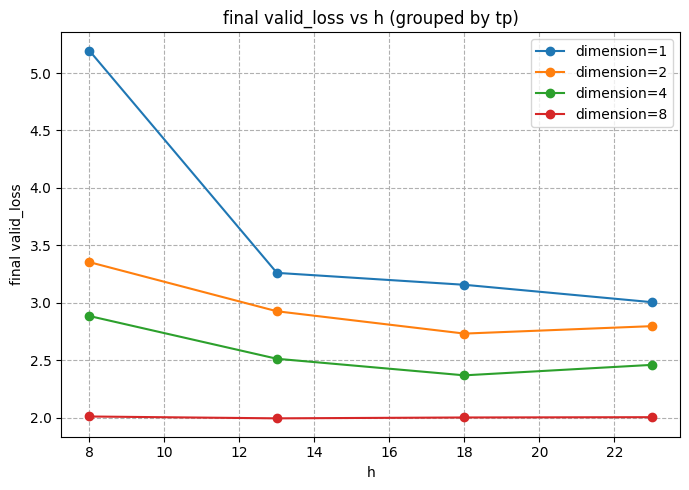

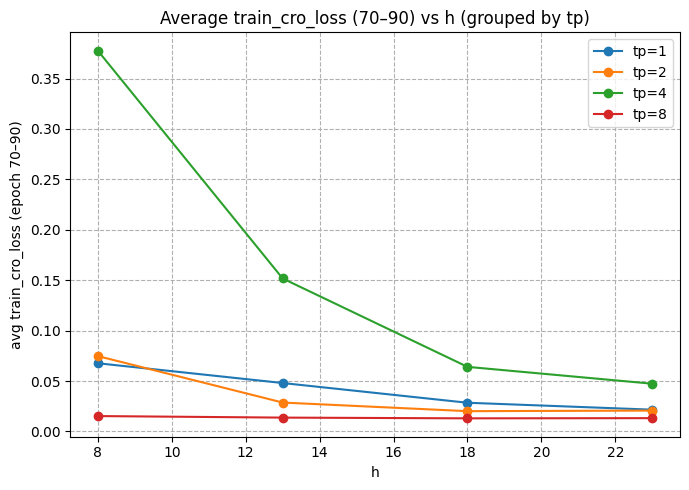

In [5]:
# =========================
# Step 0: 依赖
# =========================
import os
import re
from typing import Dict, List, Any
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Step 1: 文件名生成层
# =========================
def make_log_filename(h: int, tp: int, prefix: str = "h") -> str:
    """
    根据 h, tp 生成文件名
    """
    return f"{prefix}{h}_tp{tp}.log"

def make_log_filenames(h_list, tp_list, prefix="h") -> List[str]:
    """
    批量生成文件名
    """
    return [make_log_filename(h, tp, prefix) for h in h_list for tp in tp_list]

def list_existing_logs(log_dir: str, candidates: List[str]) -> List[str]:
    return [os.path.join(log_dir, f) for f in candidates if os.path.exists(os.path.join(log_dir, f))]

# =========================
# Step 2: 解析引擎层（单文件）
# =========================
FNAME_RE = re.compile(r"^h(?P<h>\d+)_tp(?P<tp>\d+)\.log$")


FLOAT = r"[-+]?(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][-+]?\d+)?"
TRAIN_SUMMARY_RE = re.compile(r"^epoch\s+(\d+)\s+summary:\s+(.*)$")
TRAIN_KV_RE      = re.compile(rf"(\w+_loss)\s*:\s*({FLOAT})")
VALID_SUMMARY_RE = re.compile(r"^epoch\s+(\d+)\s+summary:\s+.*(valid_cos_loss)\s*:\s*(" + FLOAT + r")")
VALID_LINE_RE    = re.compile(r"^valid loss:\s*(" + FLOAT + r")\b")

def parse_filename_meta(filename: str) -> Dict[str, Any]:
    m = FNAME_RE.match(filename)
    if not m:
        return {"file": filename, "h": None, "tp": None}
    return {"file": filename, "h": int(m.group("h")), "tp": int(m.group("tp"))}

def parse_log_file(filepath: str) -> Dict[str, Any]:
    meta = parse_filename_meta(os.path.basename(filepath))
    series: Dict[str, List[float]] = {
        "train_cos_loss": [], "train_cro_loss": [], "train_tot_loss": [], "vocab_cos_loss": [],
        "valid_cos_loss": [], "valid_loss": []
    }
    epochs_train: List[int] = []
    epochs_valid: List[int] = []
    last_epoch_seen: int | None = None

    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()

            mt = TRAIN_SUMMARY_RE.match(line)
            if mt:
                ep = int(mt.group(1))
                last_epoch_seen = ep
                kv_part = mt.group(2)
                for k, v in TRAIN_KV_RE.findall(kv_part):
                    if k in series:
                        series[k].append(float(v))
                epochs_train.append(ep)
                continue

            mv = VALID_SUMMARY_RE.match(line)
            if mv:
                ep_v = int(mv.group(1))
                last_epoch_seen = ep_v
                val_cos = float(mv.group(3))
                series["valid_cos_loss"].append(val_cos)
                epochs_valid.append(ep_v)
                continue

            ml = VALID_LINE_RE.match(line)
            if ml:
                vloss = float(ml.group(1))
                series["valid_loss"].append(vloss)
                if last_epoch_seen is not None and (not epochs_valid or epochs_valid[-1] != last_epoch_seen):
                    epochs_valid.append(last_epoch_seen)

    return {"meta": meta, "series": series, "epochs_train": epochs_train, "epochs_valid": epochs_valid}

# =========================
# Step 3: 批量收集层
# =========================
def parse_multiple_logs(filepaths: List[str]) -> List[Dict[str, Any]]:
    runs = []
    for p in filepaths:
        try:
            runs.append(parse_log_file(p))
            print(f"Parsed {p}")
        except Exception as e:
            runs.append({"meta": {"file": os.path.basename(p), "h": None, "tp": None},
                         "series": {}, "error": str(e)})
    return runs

# =========================
# Step 4: 聚合与特征派生层
# =========================
def build_final_metrics_table(runs: List[Dict[str, Any]]) -> pd.DataFrame:
    """
    输出列：
    file, h, tp, final_train_cos_loss, final_train_cro_loss,
    final_train_tot_loss, final_vocab_cos_loss,
    final_valid_cos_loss, final_valid_loss
    """
    rows: List[Dict[str, Any]] = []
    for r in runs:
        meta = r.get("meta", {})
        ser  = r.get("series", {})

        def last_or_nan(lst):
            return lst[-1] if lst else float("nan")

        rows.append({
            "file": meta.get("file"),
            "h": meta.get("h"),
            "tp": meta.get("tp"),
            "final_train_cos_loss": last_or_nan(ser.get("train_cos_loss", [])),
            "final_train_cro_loss": last_or_nan(ser.get("train_cro_loss", [])),
            "final_train_tot_loss": last_or_nan(ser.get("train_tot_loss", [])),
            "final_vocab_cos_loss": last_or_nan(ser.get("vocab_cos_loss", [])),
            "final_valid_cos_loss": last_or_nan(ser.get("valid_cos_loss", [])),
            "final_valid_loss": last_or_nan(ser.get("valid_loss", [])),
        })
    return pd.DataFrame(rows)



# =========================
# Step 5: 可视化层
# =========================
def plot_valid_loss_vs_h(df_final: pd.DataFrame):
    """
    绘制 final_valid_loss vs h
    - 横轴: h
    - 纵轴: final_valid_loss
    - 不同 tp: 不同曲线
    """
    if df_final.empty:
        print("No data to plot.")
        return

    fig, ax = plt.subplots(figsize=(7, 5))

    for tp, grp in df_final.groupby("tp"):
        g = grp.dropna(subset=["final_valid_loss"]).sort_values("h")
        if g.empty:
            continue
        ax.plot(g["h"], g["final_valid_loss"], marker="o", label=f"dimension={tp}")

    ax.set_xlabel("h")
    ax.set_ylabel("final valid_loss")
    ax.set_title("final valid_loss vs h (grouped by tp)")
    ax.grid(True, ls="--")
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_avg_train_cro_loss_vs_h(runs: List[Dict[str, Any]]):
    """
    从 runs 直接计算并绘制：
    - 平均 train_cro_loss (epoch 70~90) vs h
    - 横轴: h
    - 纵轴: avg train_cro_loss (epoch 70~90)
    - 不同 tp: 不同曲线
    """
    records = []
    for r in runs:
        meta = r.get("meta", {})
        ser  = r.get("series", {})
        h, tp = meta.get("h"), meta.get("tp")
        losses = ser.get("train_cro_loss", [])

        # 取 70~90 的子区间
        if len(losses) > 70:
            end = min(91, len(losses))  # 91 因为 Python 切片右开
            sub = losses[70:end]
            avg_loss = sum(sub) / len(sub) if sub else float("nan")
        else:
            avg_loss = float("nan")

        records.append({"h": h, "tp": tp, "avg_train_cro_loss_70_90": avg_loss})

    df_plot = pd.DataFrame(records)

    fig, ax = plt.subplots(figsize=(7, 5))
    for tp, grp in df_plot.groupby("tp"):
        g = grp.dropna(subset=["avg_train_cro_loss_70_90"]).sort_values("h")
        if g.empty:
            continue
        ax.plot(g["h"], g["avg_train_cro_loss_70_90"], marker="o", label=f"tp={tp}")

    ax.set_xlabel("h")
    ax.set_ylabel("avg train_cro_loss (epoch 70–90)")
    ax.set_title("Average train_cro_loss (70–90) vs h (grouped by tp)")
    ax.grid(True, ls="--")
    ax.legend()
    plt.tight_layout()
    plt.show()



# =========================
# Step 6: 示例（按需启用）
# =========================
log_dir = "."
h_list  = [8, 13, 18, 23]
tp_list = [1, 2, 4, 8]
candidates = make_log_filenames(h_list, tp_list)
print("候选文件:", candidates)  
filepaths  = list_existing_logs(log_dir, candidates)
runs       = parse_multiple_logs(filepaths)
df_final = build_final_metrics_table(runs)
display(df_final.sort_values(["h", "tp"]))

plot_valid_loss_vs_h(df_final)
plot_avg_train_cro_loss_vs_h(runs)
# df_final = build_final_loss_table(runs)
# plot_train_loss_vs_h(df_final)